# Task 6: Bedrock model integration with Langchain Agents

In this notebook, you learn how to use a plan-and-execute agent that determines the order of actions and implements them using the tools available to the agents. 

Certain applications demand an adaptable sequence of calls to the language models and various utilities to answer a user's question. The Langchain Agent interface is flexible and can integrate external tools with LLM's reasoning. Agents can select the tool to use based on the user input. Agents are capable of using multiple tools and utilizing the output of one tool as the input for the next.

## Task 6.1: Environment setup

In this task, you set up your environment.

In [3]:
#create a service client by name using the default session.
import math
import numexpr
import json
import datetime
import sys
import os

import boto3

module_path = ".."
sys.path.append(os.path.abspath(module_path))
bedrock_client = boto3.client('bedrock-runtime',region_name=os.environ.get("AWS_DEFAULT_REGION", None))
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

Next, you create an instance of LangChain's ChatBedrock class, which allows you to interact with a conversational AI model hosted on Amazon Bedrock

In [4]:
#create an instance of the ChatBedrock
from langchain_aws import ChatBedrock

chat_model=ChatBedrock(
    model_id=model_id , 
    client=bedrock_client)

In [5]:
#invoke model
chat_model.invoke("what is AWS? Answer in a single senetence")

AIMessage(content='AWS (Amazon Web Services) is a comprehensive cloud computing platform offering a broad set of global cloud services including computing power, database storage, content delivery, and other functionalities to help businesses scale and grow.', additional_kwargs={'usage': {'prompt_tokens': 18, 'completion_tokens': 44, 'total_tokens': 62}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 18, 'completion_tokens': 44, 'total_tokens': 62}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-8bc9744e-6a1b-4b88-80f5-d428bcaab310-0', usage_metadata={'input_tokens': 18, 'output_tokens': 44, 'total_tokens': 62})

## Task 6.2: Synergizing Reasoning and Acting in Language Models Framework

In this task, the ReAct framework enables large language models to interact with external tools to obtain additional information that results in more accurate and fact-based responses.

Large language models can generate both explanations for their reasoning and task-specific responses in an alternating fashion.

Producing reasoning explanations enables the models to infer, monitor, and revise action plans, and even handle unexpected scenarios. The action step allows the models to interface with and obtain information from external sources such as knowledge bases or environments.

In [6]:
from langchain_core.tools import tool

In the next cell, you define a function `get_product_price` that serves as a tool within the Langchain framework and retrieves the price of the product specified in the query from `sales.csv` file created from previous task. It is a simple implementation to illustrate how tools can be designed to work with the Langchain framework. 

In [7]:
@tool
def get_product_price(query:str):
    "Useful when you need to lookup product price"
    import csv
    prices = {}
    try:
        file=open('sales.csv', 'r')
    except Exception as e:
        return ("Unable to look up the price for " + query)
    reader = csv.DictReader(file)
    for row in reader:
        prices[row['product_id']] = row['price']
    file.close()
    qstr=query.split("\n")[0].strip()
    try:
            return ("Price of product "+qstr+" is "+prices.get(qstr)+"\n")
    except:
            return ("Price for product "+qstr+" is not avilable"+"\n")

In the next cell, you define a function `calculator` that serves as a tool within the Langchain framework. This tool enables a language model to perform mathematical calculations by evaluating a given expression using Python's numexpr library. The tool is designed to handle cases where the expression is invalid. In that case, the tool aks the model to rethink its approach to the calculation.

In [8]:
@tool
def calculator(expression: str) -> str:
    """Use this tool to solve a math problems that involve a single line mathematical expression.
    Use math notation and not words. 
    Examples:
        "5*4" for "5 times 4"
        "5/4" for "5 divided by 4"
    """
    try:
        return str(
            numexpr.evaluate(
            expression.strip(),
            global_dict={},  
            local_dict={} # add math constants, if needed
            )
        )
    except Exception as e:
        return "Rethink your approach to this calculation"

In [9]:
tools = [get_product_price, calculator]

In the next cell, you run helper functions to print trace output to a file

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
def output_trace(element:str, trace, node=True):
    global trace_handle
    if trace_enabled:
        print(datetime.datetime.now(),file=trace_handle)
        print(("Node: " if node else "Edge: ")+ element, file=trace_handle)
        if element == "ask_model_to_reason (entry)":
            for single_trace in trace:
                print(single_trace, file=trace_handle)
        else:
            print(trace, file=trace_handle)
        print('----', file=trace_handle)
        
def consolidate_tool_messages(message):
    tool_messages=[]
    for msg in message:
        if isinstance(msg, ToolMessage):
            tool_messages.append(msg)
    return tool_messages

## Task 6.3: Building an Agent Graph

In this task, you will be creating an agent graph for a conversational AI system that can interact with external tools. The agent graph is a state machine that defines the flow of the conversation and the interaction with the tools.

In the next cell, you define nodes with associated functions that update the state based on input. Connect nodes using edges, where the graph transitions from one node to the next. Incorporate conditional edges to route the graph to different nodes based on specific conditions. Finally, compile the agent graph to prepare it for execution, handling transitions and state updates as defined.


In [11]:
from typing import Literal
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

# ToolNode is a prebuilt component that runs the tool and appends the tool result to the messages 
tool_node = ToolNode(tools)

# let the model know the tools it can access
model_with_tools = chat_model.bind_tools(tools)
    
# The following function acts as the conditional edge in the graph.
# The next node could be the tools node or the end of the chain.
def next_step(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        output_trace("next_step: Proceed to tools",last_message, node=False)
        return "tools"
    output_trace("next_step: Proceed to end",last_message, node=False)
    return "__end__"

#.The following node function invokes the model that has information about the available tools
def ask_model_to_reason(state: MessagesState):
    messages = state["messages"]
    output_trace("ask_model_to_reason (entry)", consolidate_tool_messages(messages))
    try:
        response = model_with_tools.invoke(messages)
    except Exception as e:
        output_trace("ask_model_to_reason", messages)
        output_trace("ask_model_to_reason", "Exception: "+str(e))
        return {"messages": [messages.append("Unable to invoke the model")]}
    output_trace("ask_model_to_reason (exit)", response)
    return {"messages": [response]}


agent_graph = StateGraph(MessagesState)

# Describe the nodes. 
# The first argument is the unique node name, and the second argument is the 
# function or object that will be called when the node is reached
agent_graph.add_node("agent", ask_model_to_reason)
agent_graph.add_node("tools", tool_node)

# Connect the entry node to the agent for the graph to start running
agent_graph.add_edge("__start__", "agent")

# Once the graph transitions to the tools node, the graph will transition to the agent node
agent_graph.add_edge("tools", "agent")

# The transition out of the agent node is conditional. 
# If the output from ask_model_to_reason function included a call to the tools, call the tool; 
# otherwise end the chain 
agent_graph.add_conditional_edges(
    "agent",
    next_step,
)

# Compile the graph definition so that it can run

react_agent = agent_graph.compile()

Next, you visualize the compiled graph. Observe the transition out of the agent node is conditional as indicated by the dotted line.

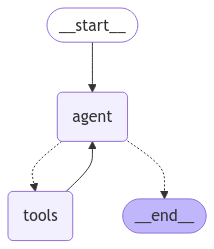

In [12]:
from IPython.display import Image, display

try:
    display(Image(react_agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In the next cell, you run helper function to print the graph output

In [13]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

Next, add one or more questions you want to ask the agent about product pricing from the sales.csv file you created in the previous notebook

In [14]:
#list of questions
questions=[]
questions.append("How much will it cost to buy 3 units of P002 and 5 units of P003?")
#questions.append("How many units of P010 can I buy with $200?")
#questions.append("Can I buy three units of P003 with $200? If not, how much more should I spend to get three units?")
#questions.append("Prices have gone up by 8%. How many units of P003 could I have purchased before the price increase with $140? How many can I buy after the price increase? Fractional units are not pssoible.")

To understand the steps involved in reasoning, enable trace. However, keep the trace output manageable by **commenting out all but one question** in the list above. Alternatively, you can disable trace and run all the questions.

In [15]:
trace_enabled=True

if trace_enabled:
    file_name="trace_"+str(datetime.datetime.now())+".txt"
    trace_handle=open(file_name, 'w')

In the next cell, you invoke the agent with the questions from the list above

In [16]:
system_message="Answer the following questions as best you can. Do not make up an answer. Think step by step. Do not perform intermediate math calculations on your own. Use the calculator tool provided for math calculations."

for q in questions:
    inputs = {"messages": [("system",system_message), ("user", q)]}
    config={"recursion_limit": 15}
    print_stream(react_agent.stream(inputs, config, stream_mode="values"))
    print("\n"+"================================ Answer complete ================================="+"\n")

if trace_enabled:
    trace_handle.close()

================================ Human Message =================================

How much will it cost to buy 3 units of P002 and 5 units of P003?
================================== Ai Message ==================================
Tool Calls:
  get_product_price (toolu_bdrk_01621yRuqukpXJYNQ4Vzmd1V)
 Call ID: toolu_bdrk_01621yRuqukpXJYNQ4Vzmd1V
  Args:
    query: P002
================================= Tool Message =================================
Name: get_product_price

Price of product P002 is 60

================================== Ai Message ==================================
Tool Calls:
  get_product_price (toolu_bdrk_01DE9bjHGrw3CcXaBEZVF5QV)
 Call ID: toolu_bdrk_01DE9bjHGrw3CcXaBEZVF5QV
  Args:
    query: P003
================================= Tool Message =================================
Name: get_product_price

Price of product P003 is 70

================================== Ai Message ==================================
Tool Calls:
  calculator (toolu_bdrk_01HTrcZNSB296vpcopj8or

### Cleanup

You have completed this notebook. To move to the next part of the lab, do the following:

- Close this notebook file and continue with the **Conclusion**.